In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [2]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [3]:
def plot_line(plt, f, t, color='y'):
    plt.plot([f[0],t[0]], [f[1],t[1]], color=color, linestyle='-', linewidth=4)

def plot_rectangle(plt, t, r, b, l):
    plot_line(plt, l, t, 'r')
    plot_line(plt, t, r, 'r')
    plot_line(plt, r, b, 'r')
    plot_line(plt, b, l, 'r')
#     plot_line(plt, t, b)
    
def plot_bbox(plt, bbox):
    if(type(bbox) == str):
        points = bbox.split()
    else:
        points = bbox
    t = (int(points[1]), int(points[0]))
    r = (int(points[3]), int(points[2]))
    b = (int(points[7]), int(points[6]))
    l = (int(points[5]), int(points[4]))
    plot_rectangle(plt, t,r,b,l)

In [4]:
f_model=resnet34
sz=768
bs=32

In [5]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        #RandomRotate(60, tfm_y=tfm_y),
        RandomLighting(0.1,0.1, tfm_y=tfm_y)
]

In [6]:
PATH = Path('../../data/airbus/')
JPEGS = 'train/'
BB_CSV = PATH/'train_ship_bbox_1_ship.csv'

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=bs)

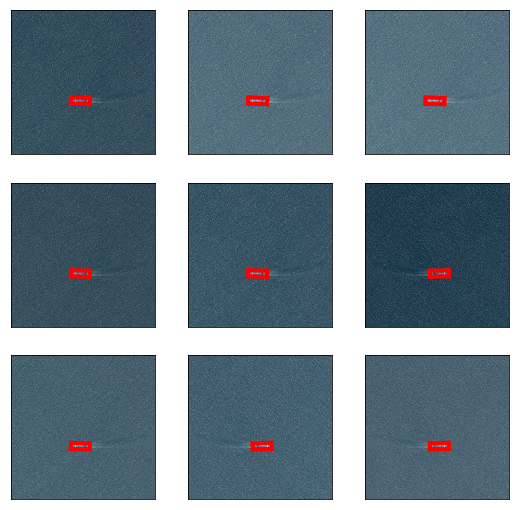

In [7]:
idx=0
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
#     y = to_np(y[idx])
#     print(y.nonzero())
    bbox = to_np(y[idx])
#     print(bbox)
    plot_bbox(ax, bbox)
    show_img(ima, ax=ax)

#     break

In [8]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(294912,8))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [9]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 768, 768]),
                           ('output_shape', [-1, 64, 384, 384]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 384, 384]),
                           ('output_shape', [-1, 64, 384, 384]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 384, 384]),
                           ('output_shape', [-1, 64, 384, 384]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 384, 384]),
                           ('output_shape', [-1, 64, 192, 192]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 19

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 59%|█████▉    | 274/464 [03:55<02:43,  1.16it/s, loss=613]

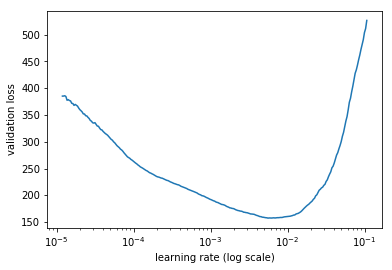

In [10]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [11]:
lr = 1e-3

In [12]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  1%|          | 4/464 [00:08<16:58,  2.21s/it, loss=361]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                             
    0      107.879265 109.153666
    1      95.831619  100.614278                            
    2      89.332966  93.20005                              



[array([93.20005])]

In [13]:
learn.save('tryout-1')

In [33]:
learn.load('tryout-1')

In [14]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

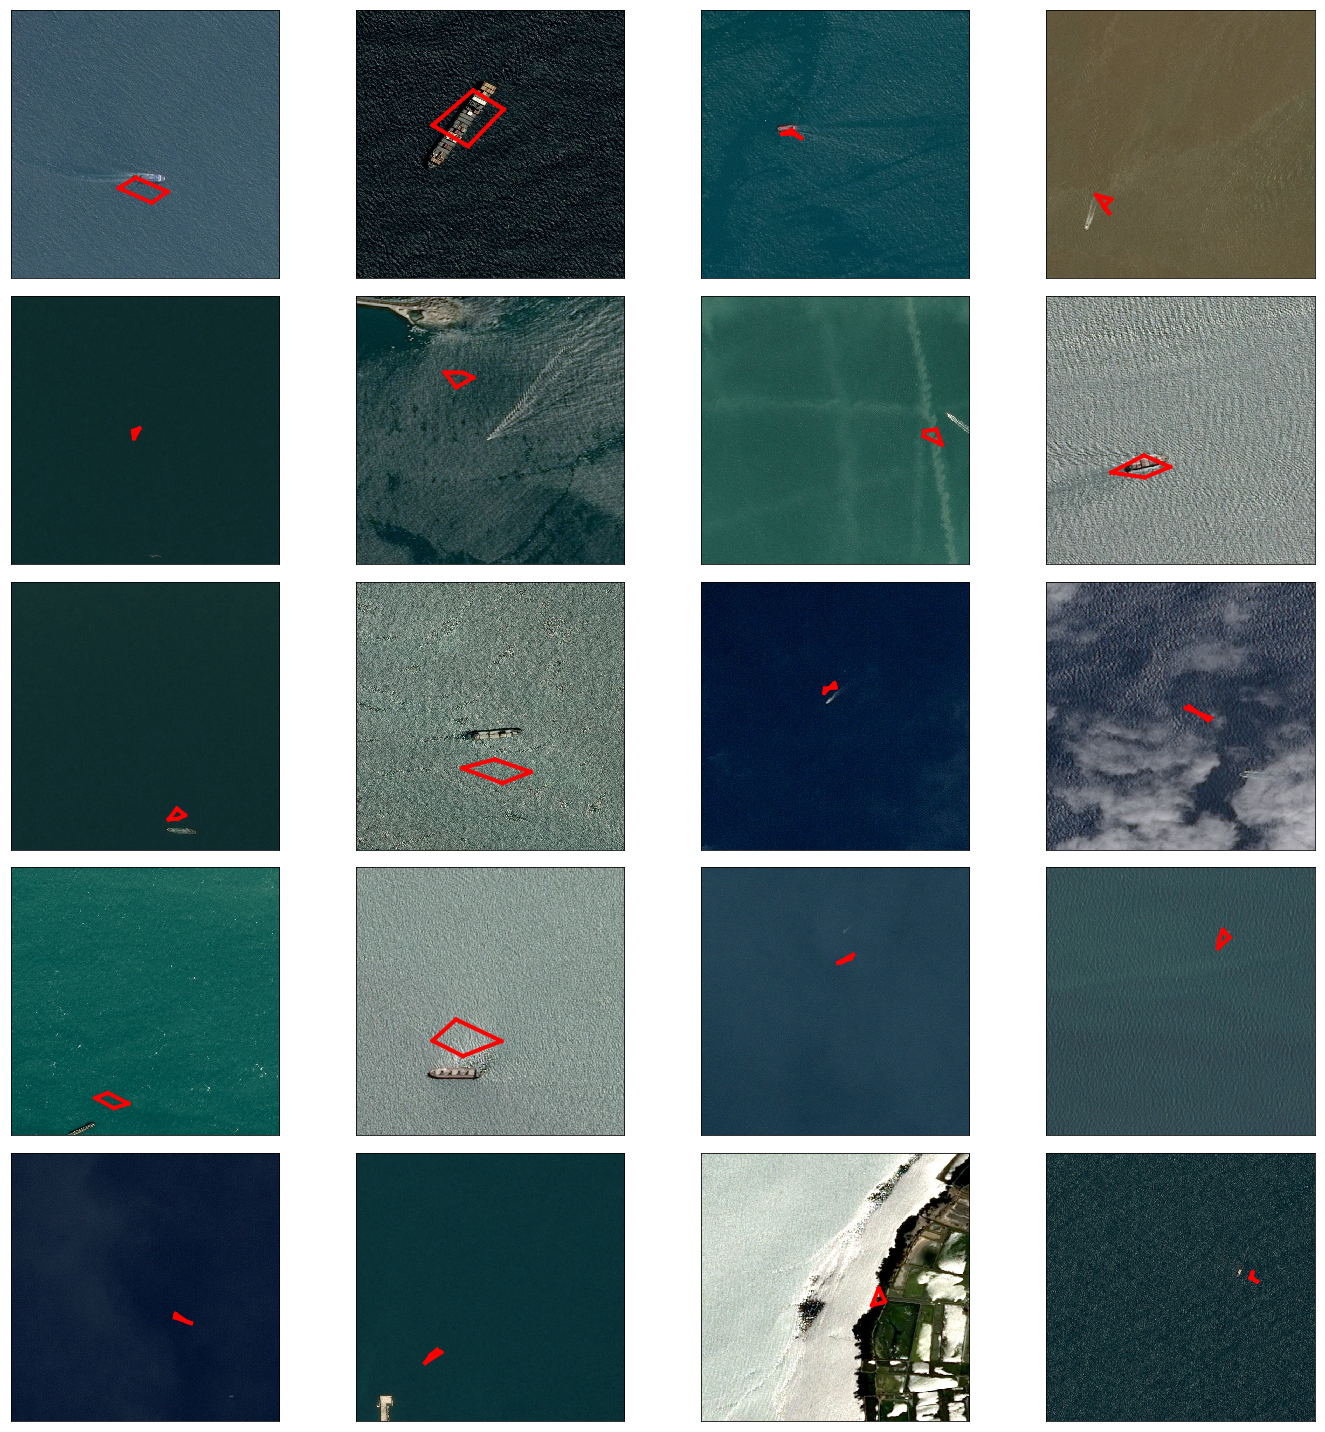

In [15]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    bbox = to_np(preds[i])
    ax = show_img(ima, ax=ax)
    plot_bbox(ax, bbox)
plt.tight_layout()

# Unfreeze addon 

In [16]:
lrs = np.array([lr/100,lr/10,lr])

In [17]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 99%|█████████▉| 460/464 [09:31<00:04,  1.24s/it, loss=384]

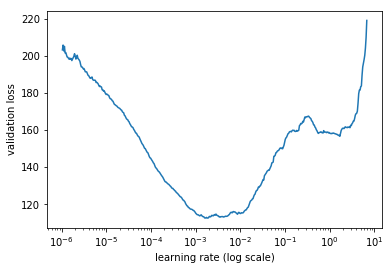

In [18]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [ ]:
lr

In [19]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  1%|          | 3/464 [00:07<20:20,  2.65s/it, loss=192]

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      53.763249  52.877642 
    1      46.583757  49.777758                             
    2      32.414041  34.239173                             



[array([34.23917])]

In [20]:
learn.save('tryout-2')

In [21]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

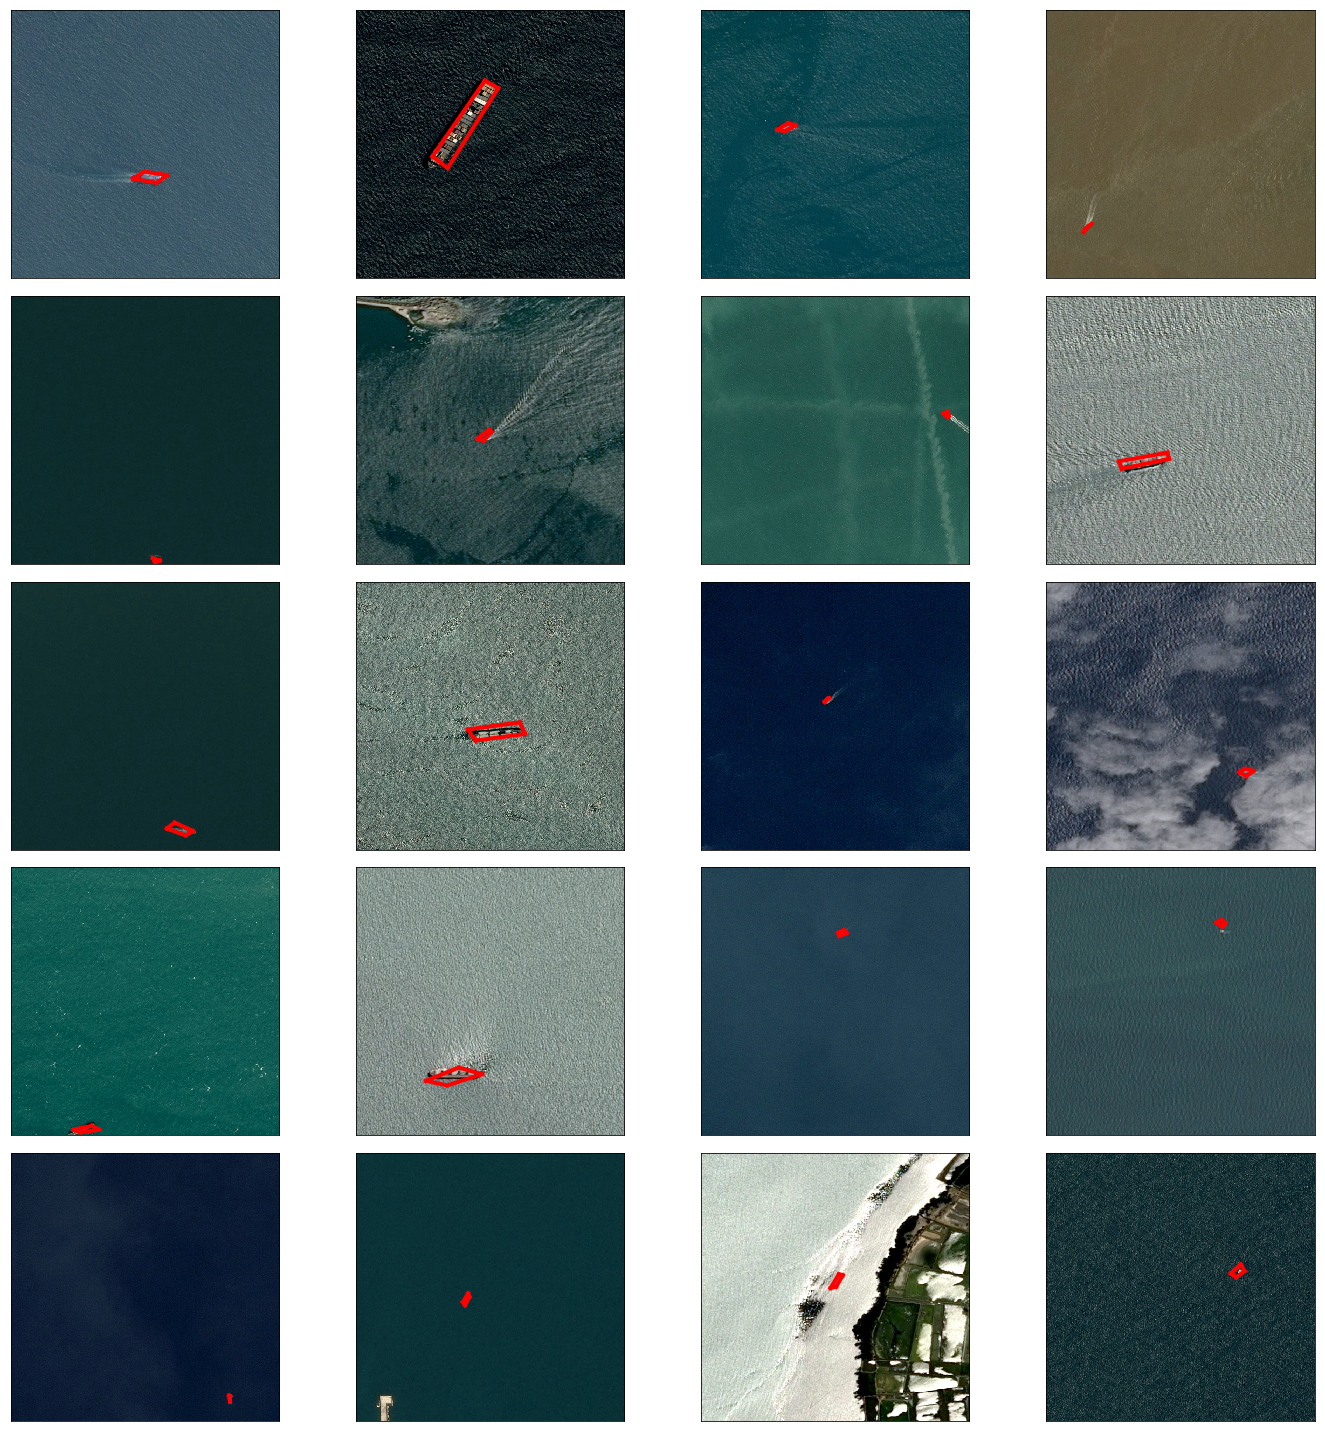

In [22]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    bbox = to_np(preds[i])
    ax = show_img(ima, ax=ax)
    plot_bbox(ax, bbox)
plt.tight_layout()